In [1]:
# Binning if needed in other classifiers
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('../data/graph_train.csv')
y = pd.cut(df['edge_cross_norm'], bins=[-1,-1e-10,1]).to_numpy()
df = df.drop(labels=['edge_cross_norm','edge_id','graph_id','num_nodes','num_edges','benchmark','max_deg','min_deg','Unnamed: 0'],axis=1)
list_columns = list(df)

for col in list_columns:
    print(col)
    if col!= 'edge_cross_norm' and col!= 'is_bridge':
        df[col] = pd.qcut(df[col],q=5)

X = df.to_numpy()
df.head()


edge_betweenness
stress
is_bridge
diff_stress
diff_cross
diff_edgelength
exp_factor_norm
sum_neighbour_deg_norm
max_neighbour_deg_norm
grad_diff


,edge_betweenness,stress,is_bridge,diff_stress,diff_cross,diff_edgelength,exp_factor_norm,sum_neighbour_deg_norm,max_neighbour_deg_norm,grad_diff
0,"(0.0451, 0.0702]","(0.0818, 0.684]",False,"(0.357, 1.41]","(-2.0, 0.0]","(-0.00824, -0.00378]","(0.0607, 0.109]","(0.158, 1.64]","(0.107, 0.92]","(0.211, 7.47]"
1,"(-0.000785, 0.0219]","(0.0818, 0.684]",False,"(-0.0453, 0.357]","(-2.0, 0.0]","(-0.00146, 0.00165]","(-0.0009714, 0.0192]","(0.158, 1.64]","(0.107, 0.92]","(0.211, 7.47]"
2,"(0.0316, 0.0451]","(0.0818, 0.684]",False,"(-0.0453, 0.357]","(-2.0, 0.0]","(-0.00146, 0.00165]","(-0.0009714, 0.0192]","(0.158, 1.64]","(0.107, 0.92]","(0.211, 7.47]"
3,"(0.0316, 0.0451]","(0.0818, 0.684]",False,"(-1.163, -0.0453]","(2.0, 39.0]","(-0.516, -0.00824]","(0.109, 0.607]","(0.158, 1.64]","(0.107, 0.92]","(0.211, 7.47]"
4,"(0.0702, 0.545]","(0.0818, 0.684]",False,"(-1.163, -0.0453]","(-2.0, 0.0]","(0.00165, 0.266]","(0.0607, 0.109]","(0.158, 1.64]","(0.107, 0.92]","(0.211, 7.47]"


In [29]:
# XGBoost data preparation 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df2 = pd.read_csv('../data/graph_train_2.csv')
df2['is_bridge'] = df2['is_bridge'].astype(float)
yn = (df2['edge_cross_norm']>0).to_numpy(dtype=int)
df2 = df2.drop(labels=['edge_cross_norm','edge_id','graph_id','num_nodes','num_edges','benchmark','max_deg','min_deg','Unnamed: 0','diff_cross','is_bridge'],axis=1)
print(df2.head())
Xn = df2.to_numpy(dtype=float)


Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn,yn,shuffle=True)

   edge_betweenness    stress  diff_stress  diff_edgelength  exp_factor_norm  \
0          0.040351  0.670386     0.209334        -0.009966         0.026218   
1          0.075299  0.504709     1.185593        -0.017250         0.095338   
2          0.047911  0.476906     1.158586        -0.017127         0.063288   
3          0.083528  0.529900    -0.085745        -0.008954         0.117927   
4          0.061404  0.444524     2.227410        -0.045941         0.093177   

   sum_neighbour_deg_norm  max_neighbour_deg_norm  
0                0.263158                0.157895  
1                0.368421                0.210526  
2                0.315789                0.157895  
3                0.263158                0.157895  
4                0.368421                0.263158  


In [30]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
T = 0.5
xgb = XGBClassifier()
xgb.fit(Xn_train,yn_train,verbose = 3)
y_pred = xgb.predict_proba(Xn_test)
y_pred = np.array([1 if y[1]>T else 0 for y in y_pred])
pos = np.sum([1 if y == 1 else 0 for y in yn_test])
f1 = f1_score(yn_test,y_pred)
print(f1)
print('Amount of better:',pos)
print('Amount of neutral or worse:',len(yn_test)-pos)
print('Accuracy in test:',(sum([1 if yn_test[i]==y_pred[i] else 0 for i in range(len(y_pred))]))/len(yn_test))

c:\Users\natha\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.2218798151001541
Amount of better: 5635
Amount of neutral or worse: 13481
Accuracy in test: 0.7094057334170328


<BarContainer object of 7 artists>

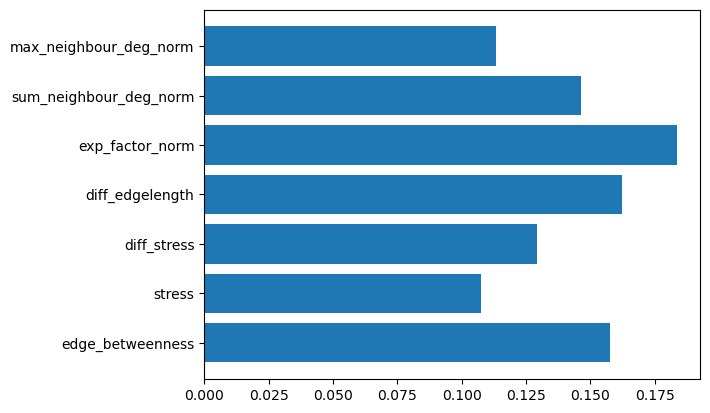

In [32]:
# Feature importance plot
import matplotlib.pyplot as plt
plt.barh(list(df2), xgb.feature_importances_)

In [4]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',silent=True, nthread=1)

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [6, 8, 10]
        }

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
grid = GridSearchCV(estimator=xgb, param_grid=params, scoring='roc_auc', n_jobs=4, cv=skf.split(Xn_train,yn_train), verbose=3 )
grid.fit(Xn_train, yn_train)

y_test = grid.best_estimator_.predict_proba(Xn_test)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits
[11:40:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[11:40:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[11:40:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[11:40:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 2/3] END colsample_bytree=0.6, gamma=0.5, max_depth=6, min_child_weight=1, subsample=0.6;, score=0.700 total time=  16.0s
[CV 3/3] END colsample_bytree=0.6, gamma=0.5, max_depth=6, min_child_weight=1, subsample=0

KeyboardInterrupt: 

In [ ]:
y_pred = [1 if y_test[i][1]>T else 0 for i in range(len(y_test))]
# Grid search useless, same results

[[0.41215986 0.58784014]
 [0.57166505 0.42833498]
 [0.9942242  0.00577581]
 ...
 [0.18812478 0.8118752 ]
 [0.6319574  0.36804262]
 [0.8036338  0.19636619]]
0.7401152394198292


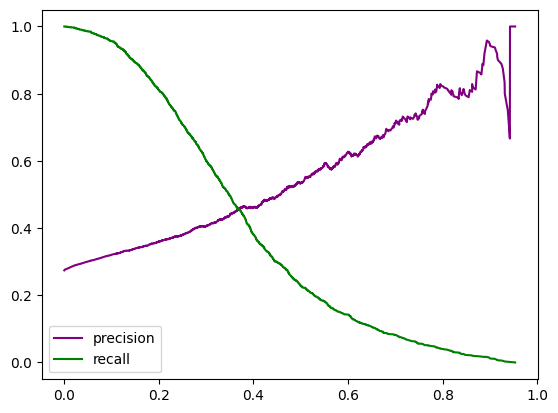

In [14]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

prec, rec, thresh = precision_recall_curve(yn_test, xgb.predict_proba(Xn_test)[:,1])

fig, ax = plt.subplots()
ax.plot(np.concatenate(([0], thresh)), prec, color='purple')
ax.plot(np.concatenate(([0], thresh)), rec, color='green')

ax.legend(['precision', 'recall'])

#display plot
plt.show()